In [2]:
%%capture
!pip install -q tensorflow keras seaborn opencv-python imutils


In [25]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import matplotlib.cm as cm
import cv2
from keras.models import load_model
from sklearn import metrics


In [5]:
FILE_PATH = r"A:\On_The_Fly_Project\fake-face-detection\real-vs-fake"
test_dir = os.path.join(FILE_PATH, "test")

print("Test folders:", os.listdir(test_dir))


Test folders: ['fake', 'real']


In [6]:
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

test_ds = image_gen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
    shuffle=False
)

test_ds.class_indices


Found 20000 images belonging to 2 classes.


{'fake': 0, 'real': 1}

In [8]:
model = load_model("real_vs_fake_model.h5")


In [9]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 836s 3s/step - accuracy: 0.9858 - loss: 0.0383
Test Loss: 0.0383
Test Accuracy: 0.9858


In [10]:
y_pred = model.predict(test_ds)
y_pred_labels = (y_pred > 0.5).astype(int)
y_true = test_ds.classes


313/313 ━━━━━━━━━━━━━━━━━━━━ 925s 3s/step


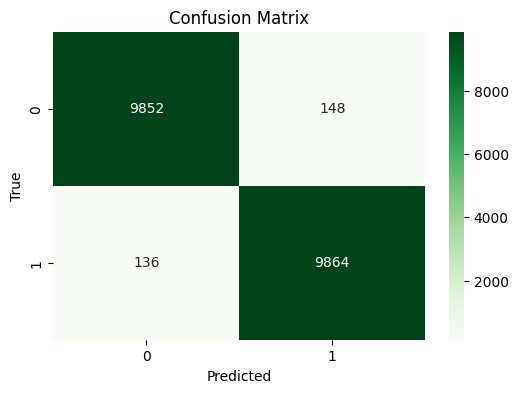

In [11]:
plt.figure(figsize=(6,4))
sns.heatmap(
    metrics.confusion_matrix(y_true, y_pred_labels),
    annot=True, fmt="d", cmap="Greens"
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [12]:
print("Accuracy:", metrics.accuracy_score(y_true, y_pred_labels))
print("Precision:", metrics.precision_score(y_true, y_pred_labels))
print("Recall:", metrics.recall_score(y_true, y_pred_labels))
print("F1 Score:", metrics.f1_score(y_true, y_pred_labels))


Accuracy: 0.9858
Precision: 0.9852177387135438
Recall: 0.9864
F1 Score: 0.9858085148910654


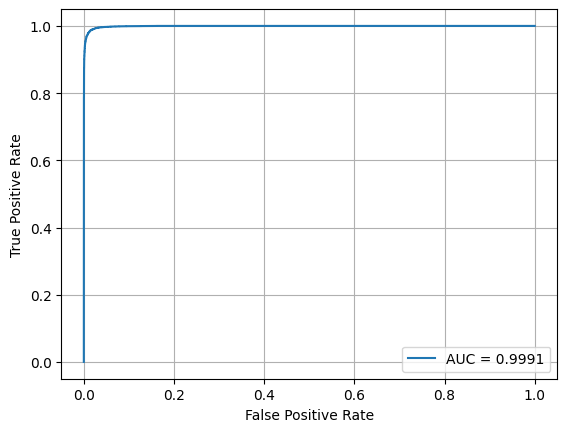

In [13]:
fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)
auc = metrics.roc_auc_score(y_true, y_pred)

plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()


In [14]:
def predict_image(model, img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256,256))
    img_arr = tf.keras.preprocessing.image.img_to_array(img)
    img_arr = np.expand_dims(img_arr, axis=0) / 255.

    pred = model.predict(img_arr)[0][0]
    label = "Real" if pred > 0.5 else "Fake"
    confidence = pred*100 if label=="Real" else (1-pred)*100

    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{label} | Confidence: {confidence:.2f}%")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


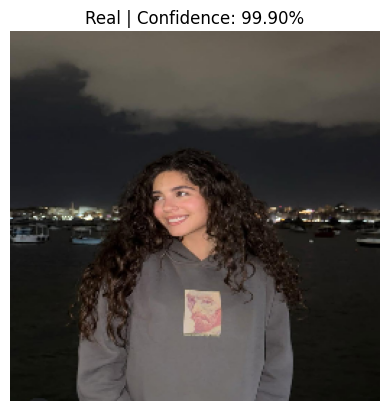

In [28]:
predict_image(
    model,
    r"A:\On_The_Fly_Project\fake-face-detection\WhatsApp Image 2025-12-22 at 1.48.49 PM.jpeg"
)


C:\Users\ahmed\AppData\Local\Temp\ipykernel_17268\1728253827.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


Result: Fake | Confidence: 95.65%


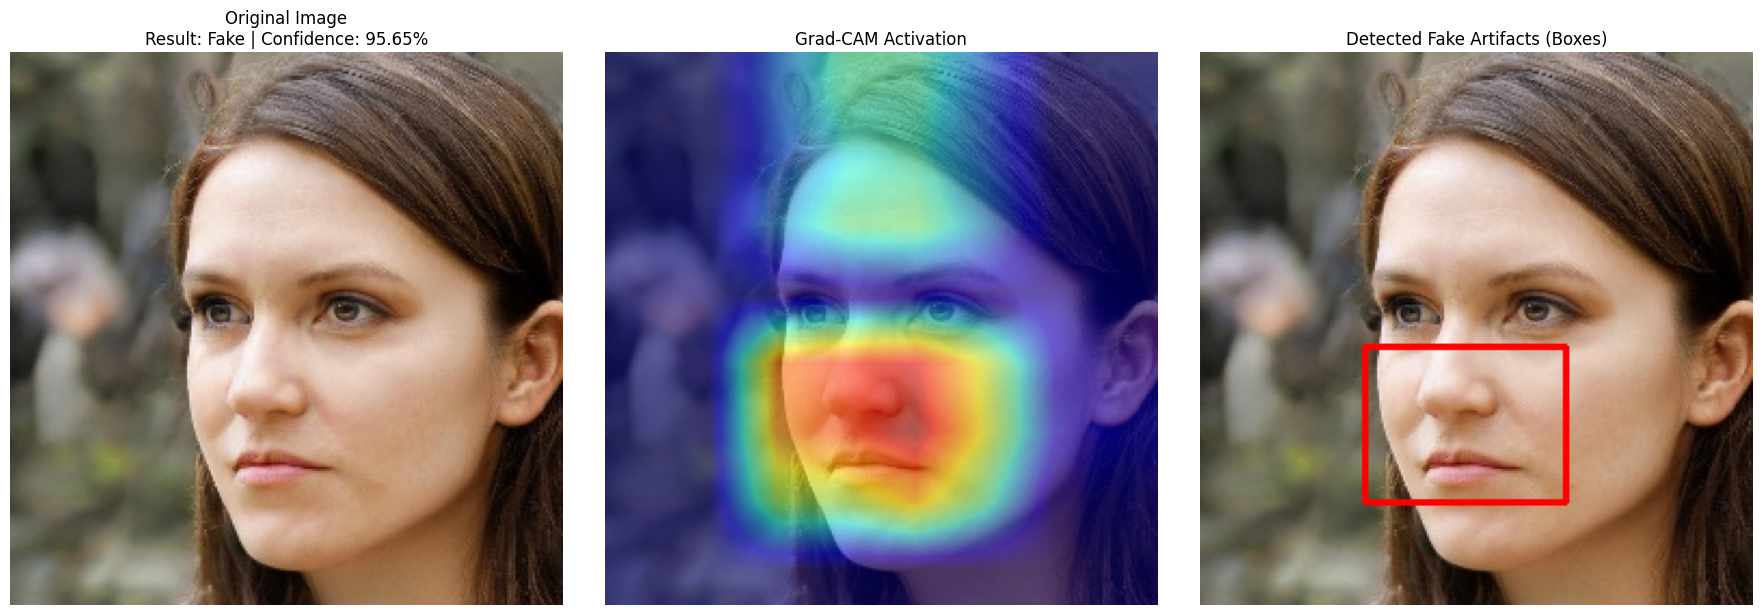

In [31]:
from keras.utils import load_img, img_to_array
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
import keras

# ================= 1. Prediction Function =================
def predict_with_confidence(model, img_array):
    pred = model.predict(img_array, verbose=0)[0][0]
    label = "Real" if pred > 0.5 else "Fake"
    confidence = (1 - pred) * 100 if label == "Fake" else pred * 100
    return label, pred, confidence

# ================= 2. Grad-CAM Heatmap Logic =================
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        class_channel = preds[0]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    if preds[0][0] < 0.5:
        grads = -grads

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-10)
    return heatmap.numpy()

# ================= 3. Visuals & Precise Boxes =================
def apply_gradcam_refined(img_path, heatmap, alpha=0.4, intensity_threshold=0.6):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    heatmap_res = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    mask = np.uint8(heatmap_res > intensity_threshold * np.max(heatmap_res)) * 255
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    boxed_img = img_rgb.copy()
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > 15 and h > 15:
            cv2.rectangle(boxed_img, (x, y), (x+w, y+h), (255, 0, 0), 2)

    heatmap_uint8 = np.uint8(255 * heatmap_res)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = np.uint8(jet_colors[heatmap_uint8] * 255)
    superimposed_img = cv2.addWeighted(jet_heatmap, alpha, img_rgb, 1-alpha, 0)

    return img_rgb, superimposed_img, boxed_img

# ================= 4. Plotting Function =================
def plot_results(original, heatmap_overlay, boxed, info_text):
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(original)
    plt.title(f"Original Image\n{info_text}")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap_overlay)
    plt.title("Grad-CAM Activation")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(boxed)
    plt.title("Detected Fake Artifacts (Boxes)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# ================= 5. MAIN EXECUTION =================
img_path = r'A:\On_The_Fly_Project\fake-face-detection\real-vs-fake\test\fake\00V5CZZSSO.jpg'
last_conv_layer_name = "conv5_block16_2_conv"

img_raw = load_img(img_path, target_size=(256, 256))
img_array = img_to_array(img_raw)
img_array = np.expand_dims(img_array, axis=0) / 255.

label, pred, conf = predict_with_confidence(model, img_array)
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

original, heatmap_overlay, boxed_img = apply_gradcam_refined(
    img_path,
    heatmap,
    alpha=0.5,
    intensity_threshold=0.7
)

info_msg = f"Result: {label} | Confidence: {conf:.2f}%"
print(info_msg)
plot_results(original, heatmap_overlay, boxed_img, info_msg)